# Read Dataset and import libraries

In [1]:
! git clone https://github.com/Ironarrow98/Zhang_Chenxi_BS6207_Final

Cloning into 'Zhang_Chenxi_BS6207_Final'...
remote: Enumerating objects: 7679, done.
remote: Counting objects: 100% (7679/7679), done.
remote: Compressing objects: 100% (7544/7544), done.
remote: Total 7679 (delta 34), reused 7654 (delta 25), pack-reused 0
Receiving objects: 100% (7679/7679), 88.06 MiB | 24.11 MiB/s, done.
Resolving deltas: 100% (34/34), done.
Checking out files: 100% (7658/7658), done.


In [2]:
! pip install sparse

     |████████████████████████████████| 77 kB 5.2 MB/s 


In [3]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
import random
import pandas as pd
from tqdm import tqdm, trange
import sparse
from sparse import COO
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D,Flatten,Dense, Dropout, BatchNormalization, Add, AveragePooling3D, Activation, GaussianNoise, Lambda
from tensorflow.keras import optimizers, losses, regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_curve, auc, classification_report

In [4]:
# Reads a up to spec pdb file and return a tuple of the
# atoms' x, y, z and atomtype
def read_pdb(filename):
  with open(filename, 'r') as file:
    strline_L = file.readlines()
  atom_list = []
  for strline in strline_L:
    # removes all whitespace at the start and end, including spaces, tabs, newlines and carriage returns
    stripped_line = strline.strip()

    line_length = len(stripped_line)
    # print("Line length:{}".format(line_length))
    if line_length < 78:
      print("ERROR: line length is different. Expected>=78, current={}".format(line_length))
        
    atom_list.append((
        stripped_line[30:38].strip(),
        stripped_line[38:46].strip(),
        stripped_line[46:54].strip(),
        'h' if stripped_line[76:78].strip() == 'C' else 'p'
        ))
        
  return np.array(atom_list, order='F')

In [5]:
raw_training_data = {
    'pro': [],
    'lig': []
}
for i in trange(3000):
  raw_training_data['pro'].append(
      read_pdb('Zhang_Chenxi_BS6207_Final/training_data/{:04d}_pro_cg.pdb'.format(i + 1)))
  raw_training_data['lig'].append(
      read_pdb("Zhang_Chenxi_BS6207_Final/training_data/{:04d}_lig_cg.pdb".format(i + 1)))

n = int(len(raw_training_data['pro']) * 0.77)
raw_training_train_data = {
    'pro': raw_training_data['pro'][:n],
    'lig': raw_training_data['lig'][:n]
}
raw_training_test_data = {
    'pro': raw_training_data['pro'][n:],
    'lig': raw_training_data['lig'][n:]
}

100%|██████████| 3000/3000 [00:08<00:00, 337.81it/s]


# Data Pre-processing

In [6]:
# Returns a sparse matrix representation of the voxel
def voxelize(pdb_inputs, max_dist, grid_resolution):
  
  def featurize(atom_type):
    feat = [0, 128]
    # Change to ligand
    if atom_type[1] == 'l':
      feat[0] = 1
    # change to polar
    if atom_type[0] == 'p':
      feat[1] = 256
    return feat
    
  max_dist = float(max_dist)
  grid_resolution = float(grid_resolution)
  box_size = np.ceil(2 * max_dist / grid_resolution)

  # merge protein and ligand
  pro_atomtypes = pdb_inputs[0]
  lig_atomtypes = pdb_inputs[1]
  pro_atomtype = np.c_[pro_atomtypes, np.full(pro_atomtypes.shape[0], 'p')]
  lig_atomtype = np.c_[lig_atomtypes, np.full(lig_atomtypes.shape[0], 'l')]
  all_atoms = np.r_[pro_atomtype, lig_atomtype]

  # center all atoms around the mean of the ligand
  cord_map = all_atoms[:, :3].astype(float)
  cord_map = cord_map - np.mean(lig_atomtype[:, :3].astype(float), axis = 0)

  # add feature list to identify the atom h/p and pro/lig
  feature_list = np.asarray([featurize(atom_type) for atom_type in all_atoms[:, -2:]])  
  atom_map = np.c_[cord_map, feature_list]

  # map all atoms to the nearest grid point
  atom_map = np.c_[cord_map, feature_list]
  atom_map[:, :3] = (atom_map[:, :3] + max_dist) / grid_resolution
  atom_map[:, :3] = atom_map[:, :3].round()
  atom_map = atom_map.astype(int)

  # remove atoms outside the box
  in_box = ((atom_map[:, :3] >= 0) & (atom_map[:, :3] < box_size)).all(axis = 1)
  atom_map = atom_map[in_box]

  # transpose the matrix
  features_list = np.squeeze(atom_map[:, -1:])
  atom_map = atom_map[:, :4].T
    
  # create the sparse matrix
  result = COO(atom_map, features_list, shape = (int(box_size), int(box_size), int(box_size), 2))
  result.sum()
  result = result.reshape((1, int(box_size), int(box_size), int(box_size), 2))
  
  return result

In [7]:
# Returns a tuple containg the training data and corresponding labels
# ratio specifies the number of negative training examples generated
# per positive training example
def generate_training_data(raw_data, max_dist, grid_resolution):
  n = len(raw_data['pro'])
  X = []
  y = []
  pro_name = []
  lig_name = []
  for i in tqdm(range(n)):

    # Generate Positive Pair
    pos_pair = voxelize((raw_data['pro'][i], 
                         raw_data['lig'][i]), 
                        max_dist, 
                        grid_resolution)
    X.append(pos_pair)
    y.append(1)
    pro_name.append(i)
    lig_name.append(i)

    # Generate Negative Pair
    pn = random.choice(range(1, n))
    ln = pn
    while ln == pn:
      ln = random.choice(range(1, n))
    neg_pair = voxelize((raw_data['pro'][pn], 
                         raw_data['lig'][ln]), 
                        max_dist, 
                        grid_resolution)
    X.append(neg_pair)
    y.append(0)
    pro_name.append(pn)
    lig_name.append(ln)

  return sparse.concatenate(X), np.asarray(y), pro_name, lig_name

In [8]:
X, y, train_pro, train_lig = generate_training_data(raw_training_data, max_dist = 40, grid_resolution = 4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42, shuffle = True, stratify = y)
train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size = 0.33, random_state = 42, shuffle = True, stratify = y_train)  

100%|██████████| 3000/3000 [00:28<00:00, 103.56it/s]


In [9]:
train_X = train_X.todense()
val_X = val_X.todense()
X_test = X_test.todense()

In [10]:
unique, counts = np.unique(train_y, return_counts=True)
dict(zip(unique, counts))

{0: 1346, 1: 1347}

In [11]:
unique, counts = np.unique(val_y, return_counts=True)
dict(zip(unique, counts))

{0: 664, 1: 663}

In [12]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 990, 1: 990}

# CNN Model

## Model Construction

In [13]:
def make_CNN(input_shape):

  inputs = Input(shape = input_shape)
  x = inputs
  x = Conv3D(filters = 32,
             kernel_size = 3,
             strides = 1,
             padding = 'same',
             kernel_initializer = 'he_normal',
             activation="relu")(x)     
  x = BatchNormalization()(x)
  x = MaxPooling3D(pool_size = 2)(x)

  x = Conv3D(filters = 64,
             kernel_size = 3,
             strides = 1,
             padding = 'same',
             kernel_initializer = 'he_normal',
             activation = "relu")(x)     
  x = BatchNormalization()(x)
  x = MaxPooling3D(pool_size = 2)(x)

  x = Conv3D(filters = 128,
             kernel_size = 3,
             strides = 1,
             padding = 'same',
             kernel_initializer = 'he_normal',
             activation = "relu")(x)     
  x = BatchNormalization()(x)
  x = MaxPooling3D(pool_size = 2)(x)

  x = Conv3D(filters = 256,
             kernel_size = 3,
             strides = 1,
             padding = 'same',
             kernel_initializer = 'he_normal',
             activation = "relu")(x)     
  x = BatchNormalization()(x)
  x = MaxPooling3D(pool_size = 2)(x)

  x = Flatten()(x)
  x = Dense(128, activation = 'relu', kernel_initializer = 'he_normal')(x)
  x = Dropout(0.5)(x)
  outputs = Dense(1, activation = 'sigmoid', kernel_initializer = 'he_normal')(x)

  return Model(inputs = inputs, outputs = outputs)

## Optimizers

In [14]:
model1 = make_CNN(input_shape=(20, 20, 20, 2))
model2 = make_CNN(input_shape=(20, 20, 20, 2))
model3 = make_CNN(input_shape=(20, 20, 20, 2))
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 20, 20, 2)]   0         
                                                                 
 conv3d (Conv3D)             (None, 20, 20, 20, 32)    1760      
                                                                 
 batch_normalization (BatchN  (None, 20, 20, 20, 32)   128       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 10, 10, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 10, 10, 64)    55360     
                                                                 
 batch_normalization_1 (Batc  (None, 10, 10, 10, 64)   256   

In [15]:
model1.compile(
    loss='binary_crossentropy',
    metrics=['acc'],
    optimizer='Adam'
)

model2.compile(
    loss='binary_crossentropy',
    metrics=['acc'],
    optimizer='SGD'
)

model3.compile(
    loss='binary_crossentropy',
    metrics=['acc'],
    optimizer='RMSprop'
)

# create a callback that will save the best model while training
save_best_model1 = ModelCheckpoint('best_model1.h5', monitor='val_acc', mode='max', save_best_only = True, verbose = 2)
save_best_model2 = ModelCheckpoint('best_model2.h5', monitor='val_acc', mode='max', save_best_only = True, verbose = 2)
save_best_model3 = ModelCheckpoint('best_model3.h5', monitor='val_acc', mode='max', save_best_only = True, verbose = 2)

history1 = model1.fit(train_X, train_y, batch_size = 64, epochs = 100, validation_data = (val_X, val_y), shuffle = True, callbacks = [save_best_model1])
history2 = model2.fit(train_X, train_y, batch_size = 64, epochs = 100, validation_data = (val_X, val_y), shuffle = True, callbacks = [save_best_model2])
history3 = model3.fit(train_X, train_y, batch_size = 64, epochs = 100, validation_data = (val_X, val_y), shuffle = True, callbacks = [save_best_model3])

Epoch 1/100
43/43 [==============================] - ETA: 0s - loss: 0.3477 - acc: 0.8819
Epoch 1: val_acc improved from -inf to 0.79955, saving model to best_model1.h5
43/43 [==============================] - 12s 42ms/step - loss: 0.3477 - acc: 0.8819 - val_loss: 2.6453 - val_acc: 0.7995
Epoch 2/100
41/43 [===========================>..] - ETA: 0s - loss: 0.1905 - acc: 0.9322
Epoch 2: val_acc improved from 0.79955 to 0.90128, saving model to best_model1.h5
43/43 [==============================] - 1s 31ms/step - loss: 0.1903 - acc: 0.9320 - val_loss: 0.6072 - val_acc: 0.9013
Epoch 3/100
43/43 [==============================] - ETA: 0s - loss: 0.1790 - acc: 0.9376
Epoch 3: val_acc improved from 0.90128 to 0.92615, saving model to best_model1.h5
43/43 [==============================] - 1s 30ms/step - loss: 0.1790 - acc: 0.9376 - val_loss: 0.1962 - val_acc: 0.9261
Epoch 4/100
43/43 [==============================] - ETA: 0s - loss: 0.1773 - acc: 0.9465
Epoch 4: val_acc improved from 0.926

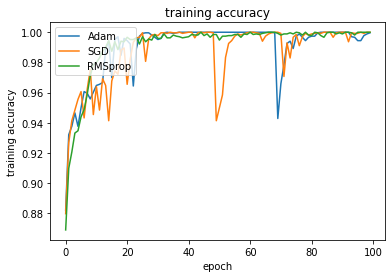

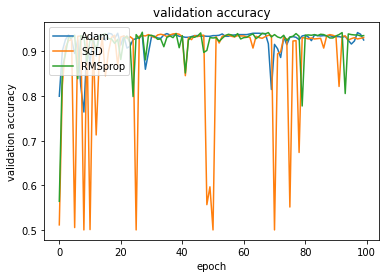

In [16]:
# Plot training accuracy
plt.plot(history1.history['acc'])
plt.plot(history2.history['acc'])
plt.plot(history3.history['acc'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Adam', 'SGD', 'RMSprop'], loc = 'upper left')
plt.show()

# Plot validation accuracy
plt.plot(history1.history['val_acc'])
plt.plot(history2.history['val_acc'])
plt.plot(history3.history['val_acc'])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['Adam', 'SGD', 'RMSprop'], loc = 'upper left')
plt.show()

## Batch Size

In [17]:
model4 = make_CNN(input_shape=(20, 20, 20, 2))
model5 = make_CNN(input_shape=(20, 20, 20, 2))
model6 = make_CNN(input_shape=(20, 20, 20, 2))
model7 = make_CNN(input_shape=(20, 20, 20, 2))

model4.compile(
    loss='binary_crossentropy',
    metrics=['acc'],
    optimizer='Adam'
)

model5.compile(
    loss='binary_crossentropy',
    metrics=['acc'],
    optimizer='Adam'
)

model6.compile(
    loss='binary_crossentropy',
    metrics=['acc'],
    optimizer='Adam'
)

model7.compile(
    loss='binary_crossentropy',
    metrics=['acc'],
    optimizer='Adam'
)

# create a callback that will save the best model while training
save_best_model4 = ModelCheckpoint('best_model4.h5', monitor='val_acc', mode='max', save_best_only = True, verbose = 2)
save_best_model5 = ModelCheckpoint('best_model5.h5', monitor='val_acc', mode='max', save_best_only = True, verbose = 2)
save_best_model6 = ModelCheckpoint('best_model6.h5', monitor='val_acc', mode='max', save_best_only = True, verbose = 2)
save_best_model7 = ModelCheckpoint('best_model7.h5', monitor='val_acc', mode='max', save_best_only = True, verbose = 2)

history4 = model4.fit(train_X, train_y, batch_size = 32, epochs = 100, validation_data = (val_X, val_y), shuffle = True, callbacks = [save_best_model4])
history5 = model5.fit(train_X, train_y, batch_size = 64, epochs = 100, validation_data = (val_X, val_y), shuffle = True, callbacks = [save_best_model5])
history6 = model6.fit(train_X, train_y, batch_size = 128, epochs = 100, validation_data = (val_X, val_y), shuffle = True, callbacks = [save_best_model6])
history7 = model7.fit(train_X, train_y, batch_size = 256, epochs = 100, validation_data = (val_X, val_y), shuffle = True, callbacks = [save_best_model7])

Epoch 1/100
81/85 [===========================>..] - ETA: 0s - loss: 0.3179 - acc: 0.8935
Epoch 1: val_acc improved from -inf to 0.64506, saving model to best_model4.h5
85/85 [==============================] - 3s 22ms/step - loss: 0.3172 - acc: 0.8927 - val_loss: 1.3488 - val_acc: 0.6451
Epoch 2/100
85/85 [==============================] - ETA: 0s - loss: 0.2168 - acc: 0.9242
Epoch 2: val_acc improved from 0.64506 to 0.92766, saving model to best_model4.h5
85/85 [==============================] - 2s 19ms/step - loss: 0.2168 - acc: 0.9242 - val_loss: 0.2089 - val_acc: 0.9277
Epoch 3/100
85/85 [==============================] - ETA: 0s - loss: 0.2093 - acc: 0.9254
Epoch 3: val_acc improved from 0.92766 to 0.93369, saving model to best_model4.h5
85/85 [==============================] - 2s 19ms/step - loss: 0.2093 - acc: 0.9254 - val_loss: 0.1770 - val_acc: 0.9337
Epoch 4/100
85/85 [==============================] - ETA: 0s - loss: 0.1791 - acc: 0.9372
Epoch 4: val_acc improved from 0.9336

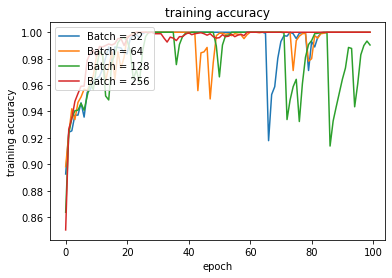

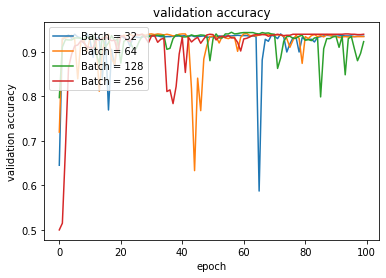

In [18]:
# Plot training accuracy
plt.plot(history4.history['acc'])
plt.plot(history5.history['acc'])
plt.plot(history6.history['acc'])
plt.plot(history7.history['acc'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Batch = 32', 'Batch = 64', 'Batch = 128', 'Batch = 256'], loc = 'upper left')
plt.show()

# Plot validation accuracy
plt.plot(history4.history['val_acc'])
plt.plot(history5.history['val_acc'])
plt.plot(history6.history['val_acc'])
plt.plot(history7.history['val_acc'])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['Batch = 32', 'Batch = 64', 'Batch = 128', 'Batch = 256'], loc = 'upper left')
plt.show()

## Learning Rate

In [19]:
model8 = make_CNN(input_shape=(20, 20, 20, 2))
model9 = make_CNN(input_shape=(20, 20, 20, 2))
model10 = make_CNN(input_shape=(20, 20, 20, 2))

model8.compile(
    loss='binary_crossentropy',
    metrics=['acc'],
    optimizer=Adam(learning_rate = 0.01)
)

model9.compile(
    loss='binary_crossentropy',
    metrics=['acc'],
    optimizer=Adam(learning_rate = 0.001)
)

model10.compile(
    loss='binary_crossentropy',
    metrics=['acc'],
    optimizer=Adam(learning_rate = 0.0001)
)

# create a callback that will save the best model while training
save_best_model8 = ModelCheckpoint('best_model8.h5', monitor='val_acc', mode='max', save_best_only = True, verbose = 2)
save_best_model9 = ModelCheckpoint('best_model9.h5', monitor='val_acc', mode='max', save_best_only = True, verbose = 2)
save_best_model10 = ModelCheckpoint('best_model10.h5', monitor='val_acc', mode='max', save_best_only = True, verbose = 2)

history8 = model8.fit(train_X, train_y, batch_size = 32, epochs = 100, validation_data = (val_X, val_y), shuffle = True, callbacks = [save_best_model8])
history9 = model9.fit(train_X, train_y, batch_size = 32, epochs = 100, validation_data = (val_X, val_y), shuffle = True, callbacks = [save_best_model9])
history10 = model10.fit(train_X, train_y, batch_size = 32, epochs = 100, validation_data = (val_X, val_y), shuffle = True, callbacks = [save_best_model10])

Epoch 1/100
81/85 [===========================>..] - ETA: 0s - loss: 0.4696 - acc: 0.8746
Epoch 1: val_acc improved from -inf to 0.89977, saving model to best_model8.h5
85/85 [==============================] - 3s 21ms/step - loss: 0.4594 - acc: 0.8767 - val_loss: 0.8862 - val_acc: 0.8998
Epoch 2/100
85/85 [==============================] - ETA: 0s - loss: 0.2211 - acc: 0.9280
Epoch 2: val_acc improved from 0.89977 to 0.91711, saving model to best_model8.h5
85/85 [==============================] - 2s 19ms/step - loss: 0.2211 - acc: 0.9280 - val_loss: 0.4439 - val_acc: 0.9171
Epoch 3/100
81/85 [===========================>..] - ETA: 0s - loss: 0.2039 - acc: 0.9298
Epoch 3: val_acc improved from 0.91711 to 0.93218, saving model to best_model8.h5
85/85 [==============================] - 2s 19ms/step - loss: 0.2037 - acc: 0.9291 - val_loss: 0.1857 - val_acc: 0.9322
Epoch 4/100
81/85 [===========================>..] - ETA: 0s - loss: 0.2161 - acc: 0.9294
Epoch 4: val_acc did not improve from

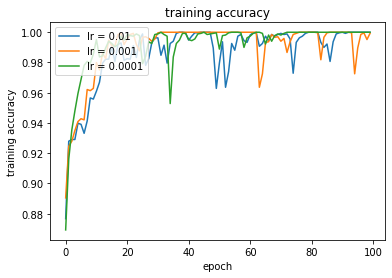

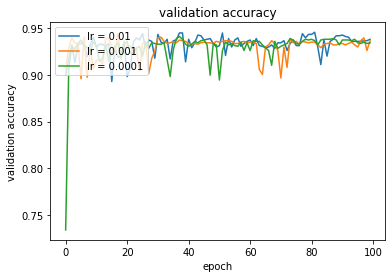

In [20]:
# Plot training accuracy
plt.plot(history8.history['acc'])
plt.plot(history9.history['acc'])
plt.plot(history10.history['acc'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['lr = 0.01', 'lr = 0.001', 'lr = 0.0001'], loc = 'upper left')
plt.show()

# Plot validation accuracy
plt.plot(history8.history['val_acc'])
plt.plot(history9.history['val_acc'])
plt.plot(history10.history['val_acc'])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['lr = 0.01', 'lr = 0.001', 'lr = 0.0001'], loc = 'upper left')
plt.show()

## Best Model Validation

In [21]:
best_model = load_model("best_model8.h5")
y_pred = best_model.predict(X_test)
y_pred

array([[1.0000000e+00],
       [2.1117018e-29],
       [6.3635404e-32],
       ...,
       [9.9995136e-01],
       [1.0000000e+00],
       [6.7989599e-25]], dtype=float32)

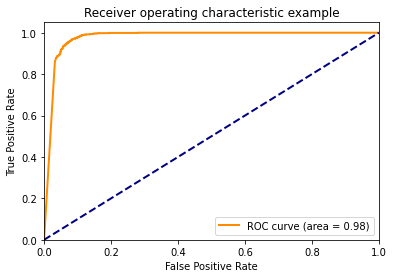

In [22]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [23]:
y_pred = np.piecewise(y_pred, [y_pred < 0.5, y_pred >= 0.5], [0., 1.]).flatten()
y_pred

array([1., 0., 0., ..., 1., 1., 0.], dtype=float32)

In [24]:
a = confusion_matrix(y_test, y_pred)
print(a)

[[915  75]
 [ 42 948]]


In [25]:
a = classification_report(y_test, y_pred, target_names=['Neg Pair', 'Pos Pair'])
print(a)

              precision    recall  f1-score   support

    Neg Pair       0.96      0.92      0.94       990
    Pos Pair       0.93      0.96      0.94       990

    accuracy                           0.94      1980
   macro avg       0.94      0.94      0.94      1980
weighted avg       0.94      0.94      0.94      1980

